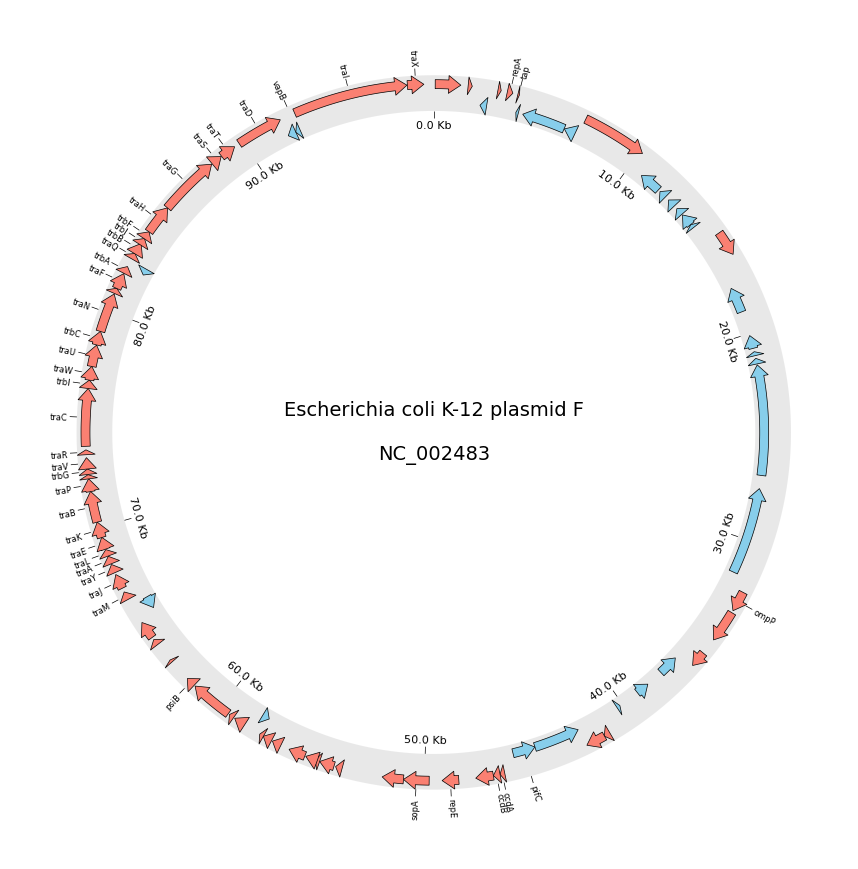

In [28]:
from pycirclize import Circos
from pycirclize.utils import fetch_genbank_by_accid
from pycirclize.parser import Genbank

# Download `NC_002483` E.coli plasmid genbank
gbk_fetch_data = fetch_genbank_by_accid("NC_002483")
gbk = Genbank(gbk_fetch_data)

# Initialize Circos instance with genome size
circos = Circos(sectors={gbk.name: gbk.range_size})
circos.text(f"Escherichia coli K-12 plasmid F\n\n{gbk.name}", size=14)
circos.rect(r_lim=(90, 100), fc="lightgrey", ec="none", alpha=0.5)
sector = circos.sectors[0]

# Plot forward strand CDS
f_cds_track = sector.add_track((95, 100))
f_cds_feats = gbk.extract_features("CDS", target_strand=1)
f_cds_track.genomic_features(f_cds_feats, plotstyle="arrow", fc="salmon", lw=0.5)

# Plot reverse strand CDS
r_cds_track = sector.add_track((90, 95))
r_cds_feats = gbk.extract_features("CDS", target_strand=-1)
r_cds_track.genomic_features(r_cds_feats, plotstyle="arrow", fc="skyblue", lw=0.5)

# Plot 'gene' qualifier label if exists
labels, label_pos_list = [], []
for feat in gbk.extract_features("CDS"):
    start = int(str(feat.location.start))
    end = int(str(feat.location.end))
    label_pos = (start + end) / 2
    gene_name = feat.qualifiers.get("gene", [None])[0]
    if gene_name is not None:
        labels.append(gene_name)
        label_pos_list.append(label_pos)
f_cds_track.xticks(label_pos_list, labels, label_size=6, label_orientation="vertical")

# Plot xticks (interval = 10 Kb)
r_cds_track.xticks_by_interval(
    10000, outer=False, label_formatter=lambda v: f"{v/1000:.1f} Kb"
)

circos.savefig("example02.png")

In [29]:
import time
import ncbi.datasets.openapi
from pprint import pprint
from ncbi.datasets.openapi.api import gene_api
from ncbi.datasets.openapi.model.rpc_status import RpcStatus
from ncbi.datasets.openapi.model.v1_download_summary import V1DownloadSummary
from ncbi.datasets.openapi.model.v1_fasta import V1Fasta
from ncbi.datasets.openapi.model.v1_gene_dataset_request import V1GeneDatasetRequest
from ncbi.datasets.openapi.model.v1_gene_dataset_request_content_type import V1GeneDatasetRequestContentType
from ncbi.datasets.openapi.model.v1_gene_dataset_request_sort_field import V1GeneDatasetRequestSortField
from ncbi.datasets.openapi.model.v1_gene_match import V1GeneMatch
from ncbi.datasets.openapi.model.v1_gene_metadata import V1GeneMetadata
from ncbi.datasets.openapi.model.v1_organism import V1Organism
from ncbi.datasets.openapi.model.v1_organism_query_request_tax_rank_filter import V1OrganismQueryRequestTaxRankFilter
from ncbi.datasets.openapi.model.v1_ortholog_request_content_type import V1OrthologRequestContentType
from ncbi.datasets.openapi.model.v1_ortholog_set import V1OrthologSet
from ncbi.datasets.openapi.model.v1_sci_name_and_ids import V1SciNameAndIds
from ncbi.datasets.openapi.model.v1_sort_direction import V1SortDirection
# Defining the host is optional and defaults to https://api.ncbi.nlm.nih.gov/datasets/v1
# See configuration.py for a list of all supported configuration parameters.
configuration = ncbi.datasets.openapi.Configuration(
    host = "https://api.ncbi.nlm.nih.gov/datasets/v1"
)

# The client must configure the authentication and authorization parameters
# in accordance with the API server security policy.
# Examples for each auth method are provided below, use the example that
# satisfies your auth use case.

# Configure API key authorization: ApiKeyAuthHeader
configuration.api_key['ApiKeyAuthHeader'] = '211dd1b92cbb746f313aff6e2956a6f90a09'

# Uncomment below to setup prefix (e.g. Bearer) for API key, if needed
# configuration.api_key_prefix['ApiKeyAuthHeader'] = 'Bearer'

def download(geneId):
    # Enter a context with an instance of the API client
    with ncbi.datasets.openapi.ApiClient(configuration) as api_client:
        # Create an instance of the API class
        api_instance = gene_api.GeneApi(api_client)
        gene_ids = geneId # [int] | NCBI gene ids
        include_annotation_type = [V1Fasta("FASTA_UNSPECIFIED")] # [V1Fasta] | Select additional types of annotation to include in the data package.  If unset, no annotation is provided. (optional)
        fasta_filter = ["fasta_filter_example",] # [str] | Limit the FASTA sequences in the datasets package to these transcript and protein accessions (optional)
        filename = "ncbi_dataset.zip" # str | Output file name. (optional) (default to "ncbi_dataset.zip")

        api_response =  api_instance.download_gene_package(gene_ids, include_annotation_type=include_annotation_type, fasta_filter=fasta_filter, filename=filename)
        print(api_response)
        return api_response

In [30]:
#https://algae.biocyc.org/
fna = './ncbi_dataset/data/rna.fna'
from Bio import SeqIO
str(next(SeqIO.parse(fna, 'fasta')).seq)

'AACCTGAAAGACAAGGCCGACGCAGCATGGAGCCGAGACCCCGCGTGGAGAGCTCCGGCGCGCTCAACGACGTGTACGTGAAAAGCCAGGAGCACCTGCTCAGGCCGACGTCCGAGAACCCGCTGCCGACCTCCGTCCCACCGCCCTCGGCCGGGATGGCAGGCCTGATCGGCGTGCGCCATGTTCTCATCGTGATTGGTCTGCCGGAGCGCGGCAAGTGCTTCATCGCACAGCGTCTCTCAAAGTACCTCTACTTTTTCCACGGCGCAGAGGTCAAGCTCTTTGACGTCGCAGAGTACATGGGCTGCCAGCCCGTCGACATTGGCCACGCGGCGCAACCGCAGGACGAGTGTCGCATCGAGGCGTCGGCCAACACGCTCACGCGCGACCTCAAGCTCTTCCTCAACTCGTCGGGCGAGGCGGCGAGGCGGGCGGGCGGGAACATGACGGTGCCGGTGCCGCGGAACTGCCAGACCGCGCAGGCGCGCGCCGCCGAGCGGGCGATGGCGGCGGCGCGCGAGGAGATCCAGAACACCGAGCAGCACCTCTTGGTGGACGAGGCGGACCGGCGGCGCAAGAATGTCGACTCGGGCAAGGTGGCCATCATCTTCACGTCAGACGGGATGGGTAGCTTCTACGAGAAGTGGGCGTGCACCTCCAAGGAGCGGCGGCGCTGGGCGGCCGAGACCATCCAGTCAGACAAGCGCCTCGGTGCCAAGGTGATCTTCATCGAGGTGATAGTCAACTCGGCAAAGCTCATGGAGCAAAACCTGCTGTCCAAGATCCGCCATGAGCGGCGCCTCTCTCGCGGCGCGGAGGCGCGCGACTCGCGCGACTCGCGCCAGTCGCGCGAGGGGGAGGAGAACGCGCGCGGCATCGCCGTGCCCTCCTCGCCCGCCACCCCCGGCAGGCCGACCCGGGCCAGCTCCTCGCGCAATCATGGGTACGGCTCCGGATACGACTGGTCCGCCGCCGCCGCCGAAGCCCTCGAGGAGAGCG

In [ ]:
import torch
from enformer_pytorch import Enformer

model = Enformer.from_hparams(
    dim = 1536,
    depth = 11,
    heads = 8,
    output_heads = dict(human = 5313, mouse = 1643),
    target_length = 896,
)
    
seq = torch.randint(0, 5, (1, 196_608)) # for ACGTN, in that order (-1 for padding)
output = model(seq)

output['human'] # (1, 896, 5313)
output['mouse'] # (1, 896, 1643)

In [ ]:

lines = []
with open('./gene_result.txt') as geneResult:
    for line in geneResult:
        lines.append(line.split('\t'))
        #geneResult.read().split('\n')
lines = lines[1:]

In [ ]:
s = str(next(SeqIO.parse(fna, 'fasta')).seq)


for i in range(len(s)):
    seq = s[i:i+3]

In [ ]:
s =str(next(SeqIO.parse('./maize.fasta', 'fasta')).seq)

lookingForThisGene = s[100:200]


def findIndex():
    for i in range(len(s)):
        s[i] 

In [ ]:
import subprocess
import math
#from StringIO import StringIO
def extract_zip(input_zip):
    input_zip=ZipFile(input_zip)
    return {name: input_zip.read(name) for name in input_zip.namelist()}

names = []
for l in range(0, math.floor(len(lines) / 10), 10):
    print(l)
    if Path.exists(f"./archive/{l}.zip"): continue
    geneId = [(item[2]) for item in lines[l:l+10]]
    api_response = download([int(g) for g in geneId])
    names.append(api_response)
    #runThis = reqiores join ['datasets', 'download', 'gene', 'gene-id', '17252077', '42265561', '54106928', '42265467', '2673707', '857442', '42265564', '54106925', '17286490', '17265309', '--filename', f'{l}.zip']
    #subprocess.run(runThis)
    #print(extract_zip('human-reference.zip'))

In [ ]:
#https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7698662/
def _():
    return 1
# dont lose momentum
# create momentum
# ignore everything - just type.

In [ ]:
from pathlib import Path

path_exists = Path.exists("home/dir/file.txt")

In [ ]:
import zipfile

with zipfile.ZipFile(names[3]) as zipf:
    # List the names of the files in the ZIP
    filenames = zipf.namelist()

    for name in filenames:
        # Extract each file
        file_data = zipf.read(name)

        # Do something with the extracted file data
        print(f"Contents of {name}:")
        print(file_data.decode('utf-8'))  

In [ ]:
names

from zipfile import ZipFile

with ZipFile('filename.zip', 'r') as f:
    f.extractall()

In [ ]:
names[0].read()

In [ ]:
from Bio import SeqIO
from orffinder import orffinder

sequences = SeqIO.parse("maize.fasta", "fasta")

In [ ]:
lotsOfLetters = next(sequences)

In [ ]:
z = str(lotsOfLetters.seq)

In [ ]:
openReadingFrame = orffinder.getORFs(next(sequences), minimum_length=75, remove_nested=True)

In [ ]:
#protein interaction network

foundGenes = [] #tuple, seqIndex, charIndex



foundGenes = []
for seq in sequences:
    for gene in geneResult:
        for orf in openReadingFrame:
#             start = orf['start']
#             end = orf['end']
            if seq[start:end] === gene:
                
            if seq[start:end] === gene: 
                foundGenes.append(o)
    

In [24]:
os.listdir('./data_sets/Astgub1/Mycocosm/Annotation/Filtered Models (_best_)/Transcripts')

['Astgub1_GeneCatalog_transcripts_20230516.nt.fasta.gz']

In [27]:
import os
base = './data_sets/Astgub1/'
os.listdir(base)

from Bio import SeqIO

sequences = SeqIO.parse(base + 'Astgub1_AssemblyScaffolds_Repeatmasked.fasta', 'fasta')
(next(sequences).seq)[5:1000]

Seq('CAGTTGCCATGCAGACCATTAGCGGCCGCTCCCTTGCGGGGCGCACCACAAGGG...agg')